# Yolov5 theory and hands-on programming
## Architecture of the network
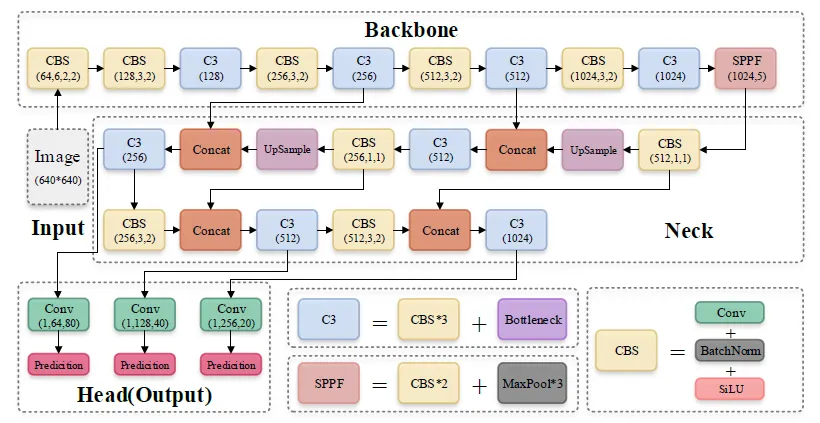

## Yolov5 different versions of the model
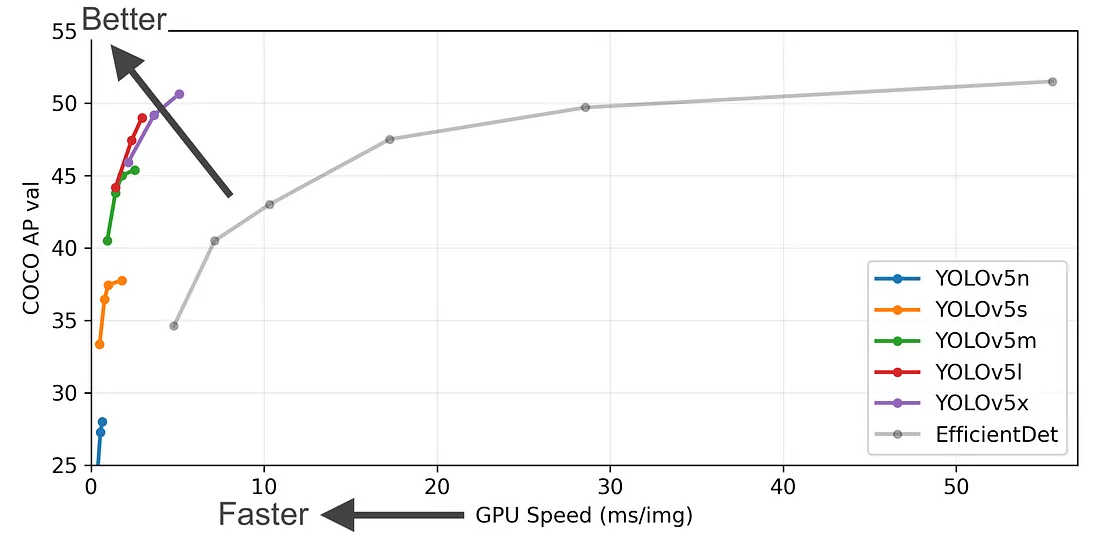

The YOLOv5 (You Only Look Once, version 5) algorithm is an advanced object detection architecture that allows identifying and locating multiple objects in an image in real-time. This version introduces improvements in efficiency and accuracy compared to its predecessors, using advanced processing techniques and optimized neural network architectures. Below are the main components of YOLOv5 and their functioning.
Main Components

* Backbone: The main section of the network that extracts features from the input image. It uses a series of convolutional blocks (CBS), C3 blocks, and * SPPF to process the image at different scales and depths.
* Neck: The intermediate part of the network that refines and combines the features extracted by the Backbone. It uses upsampling and concatenation operations to fuse features at different scales, followed by more C3 blocks.
* Head: The final part of the network that generates the final predictions. It produces three outputs at different scales to capture objects of various sizes, using CBS and C3 blocks to refine the features and final convolutions to generate the predictions for class and location.

Explanatory Points

* Network Input: The network takes a fixed-size input image (e.g., 640x640 pixels).
* Feature Extraction: The Backbone processes the image to extract features at different levels of abstraction using convolutional and aggregation blocks.
* Feature Fusion: The Neck combines and refines these features, allowing the network to capture both global and local information.
* Multiscale Predictions: The Head generates predictions at three different scales to detect small, medium, and large objects in the image.
* Efficiency and Accuracy: YOLOv5 is designed to be highly efficient, allowing real-time detection without sacrificing accuracy.

This approach enables YOLOv5 to achieve an excellent balance between speed and accuracy, making it suitable for real-time applications such as surveillance, autonomous driving, and robotic interaction.

## Hands-on programming of the Yolov5 model

In [4]:
# Import necesary libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Concatenate, UpSampling2D, MaxPool2D
from tensorflow.keras import Model, Input

# Define the different blocks
def CBS(filters, kernel_size, strides):
    """CBS block (Conv + BatchNorm + SiLU)"""
    return tf.keras.Sequential([
        Conv2D(filters, kernel_size, strides=strides, padding='same'),
        BatchNormalization(),
        tf.keras.layers.Activation('swish')
    ])

def C3(filters, num_blocks=3):
    """C3 block (Conv + CBS)"""
    layers = [CBS(filters, 1, 1) for _ in range(num_blocks)]
    return tf.keras.Sequential(layers + [CBS(filters, 3, 1)])

def SPPF(filters):
    """SPPF block (MaxPool + Conv)"""
    return tf.keras.Sequential([
        CBS(filters, 1, 1),
        CBS(filters, 3, 1),
        CBS(filters, 1, 1),
        MaxPool2D(pool_size=5, strides=1, padding='same')
    ])

# Implement the Backbone
def build_backbone(input_shape):
    inputs = Input(input_shape)

    x = CBS(64, 6, 2)(inputs)
    x = CBS(128, 3, 2)(x)
    x = C3(128)(x)
    x = CBS(256, 3, 2)(x)
    route1 = C3(256)(x)
    x = CBS(512, 3, 2)(route1)
    route2 = C3(512)(x)
    x = CBS(1024, 3, 2)(route2)
    x = C3(1024)(x)
    x = SPPF(1024)(x)

    return Model(inputs, [route1, route2, x], name='Backbone')


# Implement the Neck
def build_neck(backbone_outputs):
    route1, route2, x = backbone_outputs

    x = UpSampling2D()(x)
    x = CBS(512, 1, 1)(x)
    x = Concatenate()([x, route2])
    x = C3(512)(x)

    x = UpSampling2D()(x)
    x = CBS(256, 1, 1)(x)
    x = Concatenate()([x, route1])
    x = C3(256)(x)

    return x

# Implement the Head (output)
def build_head(neck_output):
    x = CBS(256, 3, 1)(neck_output)
    prediction1 = Conv2D(64, 1, activation='sigmoid')(x)

    x = CBS(512, 3, 2)(neck_output)
    x = C3(512)(x)
    prediction2 = Conv2D(128, 1, activation='sigmoid')(x)

    x = CBS(1024, 3, 2)(x)
    x = C3(1024)(x)
    prediction3 = Conv2D(256, 1, activation='sigmoid')(x)

    return [prediction1, prediction2, prediction3]



def build_yolov5(input_shape=(640, 640, 3)):
    inputs = Input(input_shape)

    backbone_model = build_backbone(input_shape)
    backbone_outputs = backbone_model(inputs)
    neck_output = build_neck(backbone_outputs)
    head_outputs = build_head(neck_output)

    return Model(inputs, head_outputs, name='YOLOv5')



model = build_yolov5()
model.summary()

Model: "YOLOv5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 Backbone (Functional)       [(None, 80, 80, 256),        3458348   ['input_12[0][0]']            
                              (None, 40, 40, 512),        8                                       
                              (None, 20, 20, 1024)]                                               
                                                                                                  
 up_sampling2d_4 (UpSamplin  (None, 40, 40, 1024)         0         ['Backbone[0][2]']            
 g2D)                                                                                        